# Análisis Exploratorio de los Microdatos del Censo 2017

Por **Eduardo Graells-Garrido** y Daniela Opitz. <dopitz@udd.cl>.
Actualizado: **14 de mayo de 2024**.

En este notebook muestro cómo cargar datos del Censo 2017 para generar mapas de coropletas.

Particularmente haremos tres mapas:

  * ¿Cuál es la distribución de les inmigrantes en Santiago?
  * ¿Cuál es la distribución de las personas mayores de 65 años en Santiago?
  * ¿Dónde viven más hombres o mujeres?

Los datos se han obtenido de las siguientes fuentes (y están incluidos en este repositorio):

  * [Microdatos del Censo 2017](http://www.censo2017.cl/microdatos/)
  * [Shapefile de Distritos Censales](https://github.com/justinelliotmeyers/official_chile_2017_census_boundary_shapefile)
  * [Shapefile de áreas urbanas del país](https://www.bcn.cl/siit/mapas_vectoriales/index_html)

Comencemos.

## Preámbulo


Y descargar los datos si es que estás usando Google Colab

In [1]:
try:
    import google.colab
    !curl -L -o censo2017.zip 'https://www.dropbox.com/scl/fi/gx94xhhvwm5ncilwyt0yc/censo2017.zip?rlkey=zufb4zjrbx614gep3pra5qix5&st=pl1s7cde&dl='
    !unzip -o censo2017.zip
except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    167      0 --:--:--  0:00:01 --:--:--   167
100   491    0   491    0     0    185      0 --:--:--  0:00:02 --:--:--     0
100  295M  100  295M    0     0  11.6M      0  0:00:25  0:00:25 --:--:-- 13.8M
Archive:  censo2017.zip
   creating: censo2017/
   creating: censo2017/Censo2017_Identificación_Geográfica/
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Categorias.csv  
 extracting: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Areas.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Regiones.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Comunas.csv  
  inflating: censo2017/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Urbano.csv  
  inflating: censo2

In [2]:
try:
    import google.colab
    !curl -L -o Fira_Sans_Extra_Condensed.zip 'https://www.dropbox.com/s/82nuhtpybfpjeq9/Fira_Sans_Extra_Condensed.zip?dl=1'
    !unzip -o Fira_Sans_Extra_Condensed.zip
    import matplotlib as mpl
    mpl.font_manager.fontManager.addfont('Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Regular.ttf')
    #mpl.rc('font', family='Fira Sans Extra Condensed')
except:
    pass

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    74    0    74    0     0    256      0 --:--:-- --:--:-- --:--:--   256
100   320  100   320    0     0    188      0  0:00:01  0:00:01 --:--:--   782
100 3733k  100 3733k    0     0  1474k      0  0:00:02  0:00:02 --:--:-- 5045k
Archive:  Fira_Sans_Extra_Condensed.zip
   creating: Fira_Sans_Extra_Condensed/
  inflating: __MACOSX/._Fira_Sans_Extra_Condensed  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-MediumItalic.ttf  
  inflating: __MACOSX/Fira_Sans_Extra_Condensed/._FiraSansExtraCondensed-MediumItalic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-Italic.ttf  
  inflating: __MACOSX/Fira_Sans_Extra_Condensed/._FiraSansExtraCondensed-Italic.ttf  
  inflating: Fira_Sans_Extra_Condensed/FiraSansExtraCondensed-BlackItalic.ttf  
  inflating: __MACOSX/Fira_Sans_Extra_Condensed/._FiraSansE

Aquí cargamos las bibliotecas que necesitamos utilizar y configuramos el sistema.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font='sans-serif', context='notebook', palette='viridis')
%config InlineBackend.figure_format='retina'

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
plt.rcParams["figure.dpi"] = 96
# esto depende de las fuentes que tengas instaladas en tu sistema.
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [4]:
pd.set_option('display.max_columns', None)

## Carga de Datos

Comencemos. Lo primero que hacemos es cargar los datos. Aquí hacemos una serie de operaciones de modo de quedarnos solamente con la región metropolitana.

Es posible que mi manera de limpiar los datos no sea la adecuada. En tal caso, por favor escríbeme un correo o abre un _issue_ en este repositorio.

In [5]:
# Cargar los datos de las manzanas del censo desde un archivo CSV
manzanas = pd.read_csv('censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Manzanas.csv', sep=';')

manzanas.head()

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
0       1         11    1101   1     1       1       1         7849   
1       1         11    1101   1     1       1      10         7849   
2       1         11    1101   1     1       1      11         7849   
3       1         11    1101   1     1       1      12         7849   
4       1         11    1101   1     1       1      13         7849   

      ID_MANZENT  PERSONAS HOMBRES MUJERES EDAD_0A5 EDAD_6A14 EDAD_15A64  \
0  1101011001001        15       *       *        0         0         15   
1  1101011001010        70      38      32        *         *         54   
2  1101011001011        36      21      15        *         0         28   
3  1101011001012        65      34      31        *         7         49   
4  1101011001013        39      12      27        *         *         26   

  EDAD_65YMAS INMIGRANTES PUEBLO  VIV_PART  VIV_COL  MATACEP  MATREC  \
0           0           0      0         1        2        0       0   
1          10          12     13        17        1       14       1   
2           *          11      7        15        1       10       5   
3           *          27      4        24        0       11       9   
4           7           4     17        11        2        9       0   

   MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  P03A_4  P03A_5  P03A_6  \
0         0      0          3       0       0       0       0       0       0   
1         0     15         18       0       1      13       1       0       0   
2         0     15         16       0       0      15       0       0       0   
3         4     24         24       2       4      11       7       0       0   
4         0      9         13       0       4       5       0       0       0   

   P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  P03B_6  P03B_7  P03C_1  P03C_2  \
0       0       0       0       0       0       0       0       0       0   
1       8       0       7       0       0       0       0      15       0   
2       0       0      15       0       0       0       0      10       0   
3       5       2      13       0       0       3       1      18       1   
4       6       0       3       0       0       0       0       9       0   

   P03C_3  P03C_4  P03C_5  P05_1  P05_2  P05_3  P05_4  
0       0       0       0      0      0      0      0  
1       0       0       0     15      0      0      0  
2       0       5       0     15      0      0      0  
3       4       1       0     24      0      0      0  
4       0       0       0      9      0      0      0

Por alguna razon Google Colab no permite cargar el archivo `censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Urbano.csv` por lo que su vista preeliminar se despliega en la imagén que obtuve usando la carga de mi computador. Pero estrañamente si cargas los dos archivos a la vez, el del problema y el anterior, y los unes con merge todo funciona bien.

In [6]:
from IPython.display import Image

# URL directa a la imagen en GitHub
url = 'https://raw.githubusercontent.com/daniopitz/visualizacion/main/clases_practicas/images/clase08_censo_manzanas.png'

# Muestra la imagen
Image(url=url)


In [7]:
census = (pd.read_csv('censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Manzanas.csv', sep=';')
          .merge(pd.read_csv('censo2017/Censo2017_ManzanaEntidad_CSV/Censo2017_Identificación_Geográfica/Microdato_Censo2017-Urbano.csv', sep=';'))
          .pipe(lambda x: x[x.REGION == 13])
          .drop('ZONA', axis=1)
          .drop_duplicates()
         )
census.head()

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
531736      13        131   13101   1     1       1       3         1279   
531741      13        131   13101   1     1       1       4         1279   
531746      13        131   13101   1     1       1       5         1279   
531751      13        131   13101   1     1       1       6         1279   
531756      13        131   13101   1     1       1       7         1279   

            ID_MANZENT  PERSONAS HOMBRES MUJERES EDAD_0A5 EDAD_6A14  \
531736  13101011001003       421     196     225       24        18   
531741  13101011001004       185      90      95        *         *   
531746  13101011001005       776     390     386       30        27   
531751  13101011001006       416     209     207       14        10   
531756  13101011001007       376     211     165        *         *   

       EDAD_15A64 EDAD_65YMAS INMIGRANTES PUEBLO  VIV_PART  VIV_COL  MATACEP  \
531736        299          80          63     28       249        1      181   
531741        137          41          22     20       154        0      111   
531746        636          83         132     54       515        2      416   
531751        337          55          59     51       292        1      222   
531756        315          40          55     28       279        2      187   

        MATREC  MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  P03A_4  \
531736       0         0    189        250     159      29       0       0   
531741       0         0    115        154     108       5       0       0   
531746       1         0    422        517     385      35       0       0   
531751       1         0    225        293     196      28       0       0   
531756       1         0    195        281     140      49       1       0   

        P03A_5  P03A_6  P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  P03B_6  \
531736       0       0      32     136      15       0       0       0   
531741       0       0       1     108       2       0       0       0   
531746       1       0      60     333      25       1       0       0   
531751       1       0      91     114      19       0       0       0   
531756       1       0      27     135      28       0       0       0   

        P03B_7  P03C_1  P03C_2  P03C_3  P03C_4  P03C_5  P05_1  P05_2  P05_3  \
531736       0     186       0       0       0       0    188      0      0   
531741       0     113       0       0       0       0    113      0      0   
531746       0     419       1       0       0       0    422      0      0   
531751       0     224       0       0       0       0    222      0      0   
531756       0     191       0       0       0       0    195      0      0   

        P05_4 NOM_URBANO  CAT  
531736      0   SANTIAGO    1  
531741      0   SANTIAGO    1  
531746      0   SANTIAGO    1  
531751      0   SANTIAGO    1  
531756      0   SANTIAGO    1

Creamos una lista con las variables que nos interesan.

In [8]:
count_columns = ['HOMBRES', 'MUJERES','EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 'INMIGRANTES']

Si vemos el manual de uso de la base de datos, hay ocasiones en los que esas columnas no tienen valor. Con esto lo arreglamos, reemplazando el valor anónimo por un 0.

In [9]:
for col in count_columns:
    census[col] = census[col].replace('*', 0).astype(int)

In [10]:
census.sample(10)

REGION  PROVINCIA  COMUNA  DC  AREA  ZC_LOC  MZ_ENT  ID_ZONA_LOC  \
661944      13        131   13120   4     1       2      12         5905   
550366      13        131   13104   8     1       3      16        14087   
841047      13        136   13603   2     1       2      18        13741   
799832      13        133   13301   6     1       3      65        13466   
756455      13        132   13201  12     1       3      53         1651   
614314      13        131   13117   3     1       6      15         4519   
789515      13        132   13201   8     1       4      21         5043   
664498      13        131   13121   1     1       2      12         4909   
677564      13        131   13123   1     1       2      14        12340   
565633      13        131   13108   6     1       2       5         6856   

            ID_MANZENT  PERSONAS  HOMBRES  MUJERES  EDAD_0A5  EDAD_6A14  \
661944  13120041002012        81       30       51         5         11   
550366  13104081003016        59       29       30         0          0   
841047  13603021002018        38       22       16         0          0   
799832  13301061003065         0        0        0         0          0   
756455  13201121003053        55       28       27         0         11   
614314  13117031006015       182       93       89        16         21   
789515  13201081004021       609      285      324        46         75   
664498  13121011002012        58       27       31         0         11   
677564  13123011002014        54       25       29         0          0   
565633  13108061002005        80       46       34         0          5   

        EDAD_15A64  EDAD_65YMAS  INMIGRANTES PUEBLO  VIV_PART  VIV_COL  \
661944          57            8            4      *        24        0   
550366          34           16           10      4        23        0   
841047          27            6            0      *        14        0   
799832           0            0            0      0        13        0   
756455          38            0            8      *        18        0   
614314         136            9           63     31        53        0   
789515         443           45           19     59       187        0   
664498          38            0            0      *        20        0   
677564          37            8            0      4        22        0   
565633          70            0           11      *        16        1   

        MATACEP  MATREC  MATIRREC  VPOMP  TOTAL_VIV  P03A_1  P03A_2  P03A_3  \
661944       23       0         0     23         24      23       0       0   
550366       18       3         0     21         23       0       9      12   
841047       13       0         0     14         14       0      12       1   
799832        0       0         0      0         13       0       0       0   
756455       15       2         0     17         18       0      15       0   
614314       40      10         1     51         53      10      22      11   
789515      175       3         0    178        187       5     172       0   
664498       19       0         0     19         20       5      14       0   
677564        8       3         0     13         22       1       8       0   
565633       14       2         0     16         17       4      11       0   

        P03A_4  P03A_5  P03A_6  P03B_1  P03B_2  P03B_3  P03B_4  P03B_5  \
661944       0       0       0      22       1       0       0       0   
550366       0       0       0       0       0      21       0       0   
841047       0       0       0       2       0      12       0       0   
799832       0       0       0       0       0       0       0       0   
756455       2       0       0       1       0      16       0       0   
614314       5       3       0       9       0      41       0       0   
789515       1       0       0      24       1     152       1       0   
664498       0       0       0       7       6       6       0      

Ahora sumemos la población por cada variable, agrupando por distrito censal.

In [11]:
dc_values = census.groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])[count_columns].sum().reset_index().rename(columns={'DC': 'COD_DISTRI'})

In [12]:
dc_values.sample(5)

REGION  PROVINCIA  COMUNA  COD_DISTRI  HOMBRES  MUJERES  EDAD_0A5  \
243      13        131   13124           5     5666     5928       796   
48       13        131   13104           7     3249     3378       441   
384      13        135   13501          12     7142     7148      1136   
162      13        131   13116           5     2781     2828       376   
6        13        131   13101           7     5797     6091       946   

     EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  
243       1266        7947         1385          217  
48         641        4310         1102          624  
384       1686        9924          968          142  
162        590        3886          702          195  
6         1123        8922          808         4133

¡Listo! Con eso ya tenemos nuestros datos preparados para ser visualizados. Antes de hacer eso, nos encargaremos de quedarnos con los distritos dentro del área urbana de Santiago.

## Cargando la Geografía

Así leemos la cartografía de las áreas urbanas:

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

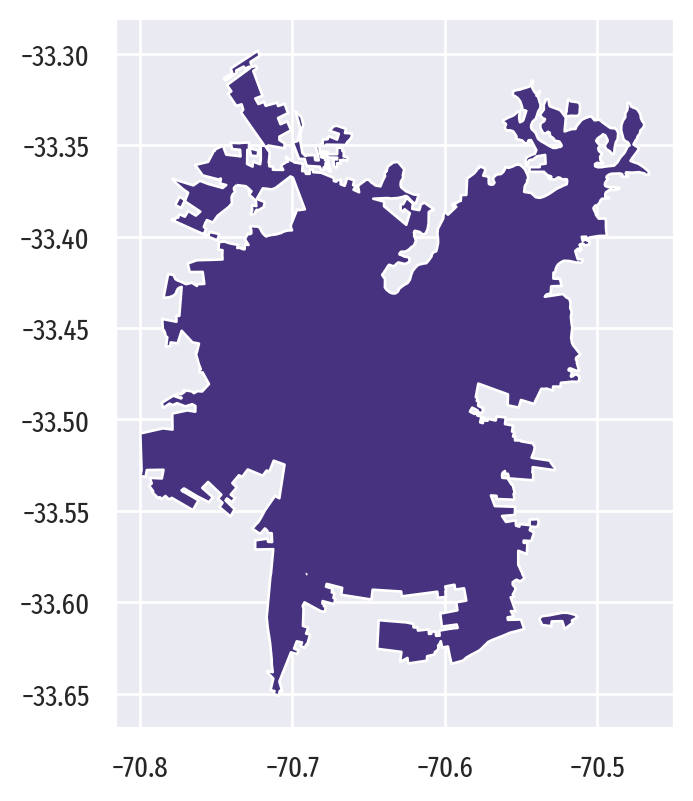

In [13]:
# Leer el archivo GeoJSON
urban_stgo = gpd.read_file('./censo2017/urban_areas/', crs={'init': 'epsg:5361'})

# Cambiar el sistema de referencia de coordenadas a EPSG:4326
urban_stgo = urban_stgo.to_crs({'init': 'epsg:4326'})

# Filtrar para obtener solo las áreas urbanas de Santiago
urban_stgo = urban_stgo[urban_stgo.NOMBRE == 'Santiago'].copy()

# Hacer el gráfico de las áreas urbanas de Santiago
urban_stgo.plot()

Esa área urbana define el borde del área que nos interesa estudiar, pero necesitamos cargar los bordes de cada distrito censal. Lo hacemos como sigue:

In [14]:
gpd.read_file('./censo2017/R13/')

REGION PROVINCIA COMUNA  COD_DISTRI                        DESC_REGIO  \
0       13       131  13114         4.0  REGIÓN METROPOLITANA DE SANTIAGO   
1       13       131  13114        15.0  REGIÓN METROPOLITANA DE SANTIAGO   
2       13       131  13114        16.0  REGIÓN METROPOLITANA DE SANTIAGO   
3       13       131  13114         2.0  REGIÓN METROPOLITANA DE SANTIAGO   
4       13       131  13114         3.0  REGIÓN METROPOLITANA DE SANTIAGO   
..     ...       ...    ...         ...                               ...   
446     13       135  13501         1.0  REGIÓN METROPOLITANA DE SANTIAGO   
447     13       135  13501         7.0  REGIÓN METROPOLITANA DE SANTIAGO   
448     13       135  13501        13.0  REGIÓN METROPOLITANA DE SANTIAGO   
449     13       135  13501         8.0  REGIÓN METROPOLITANA DE SANTIAGO   
450     13       131  13118         5.0  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI  DESC_COMUN                      DESC_DISTR  \
0     SANTIAGO  LAS CONDES                      LAS CONDES   
1     SANTIAGO  LAS CONDES         SAN CARLOS DE APOQUINDO   
2     SANTIAGO  LAS CONDES                     CERRO CALÁN   
3     SANTIAGO  LAS CONDES               ESTADIO PALESTINO   
4     SANTIAGO  LAS CONDES                   HOSPITAL FACH   
..         ...         ...                             ...   
446  MELIPILLA   MELIPILLA              MELIPILLA PONIENTE   
447  MELIPILLA   MELIPILLA                        CULIPRÁN   
448  MELIPILLA   MELIPILLA                PUANGUE PONIENTE   
449  MELIPILLA   MELIPILLA                         HUECHÚN   
450   SANTIAGO       MACUL  VILLA SANTA CAROLINA VILLA SAN   

                                              geometry  
0    POLYGON ((-70.47951 -33.36433, -70.47940 -33.3...  
1    POLYGON ((-70.50074 -33.37846, -70.50045 -33.3...  
2    POLYGON ((-70.50789 -33.38245, -70.50774 -33.3...  
3    POLYGON ((-70.53606 -33.38529, -70.53652 -33.3...  
4    POLYGON ((-70.54504 -33.39658, -70.54575 -33.3...  
..                                                 ...  
446  POLYGON ((-71.22747 -33.67002, -71.22402 -33.6...  
447  POLYGON ((-71.19488 -33.78527, -71.19403 -33.7...  
448  POLYGON ((-71.31653 -33.58829, -71.31629 -33.5...  
449  POLYGON ((-71.32236 -33.66578, -71.32134 -33.6...  
450  POLYGON ((-70.59876 -33.47380, -70.59881 -33.4...  

[451 rows x 9 columns]

In [15]:
# Leer el archivo GeoJSON
orig = gpd.read_file('./censo2017/R13/')

# Convertir las columnas a enteros
orig['REGION'] = orig['REGION'].astype(int)
orig['PROVINCIA'] = orig['PROVINCIA'].astype(int)
orig['COMUNA'] = orig['COMUNA'].astype(int)
orig['COD_DISTRI'] = orig['COD_DISTRI'].astype(int)

# Obtener la longitud del GeoDataFrame
len_orig = len(orig)
print(len_orig)

451


En la RM hay 451 áreas censales. Por cierto, los valores de región, provincia, comuna y distrito no vienen como números enteros, por eso debimos realizar esas operaciones `astype`.

Grafiquemos los distritos:

<Axes: >

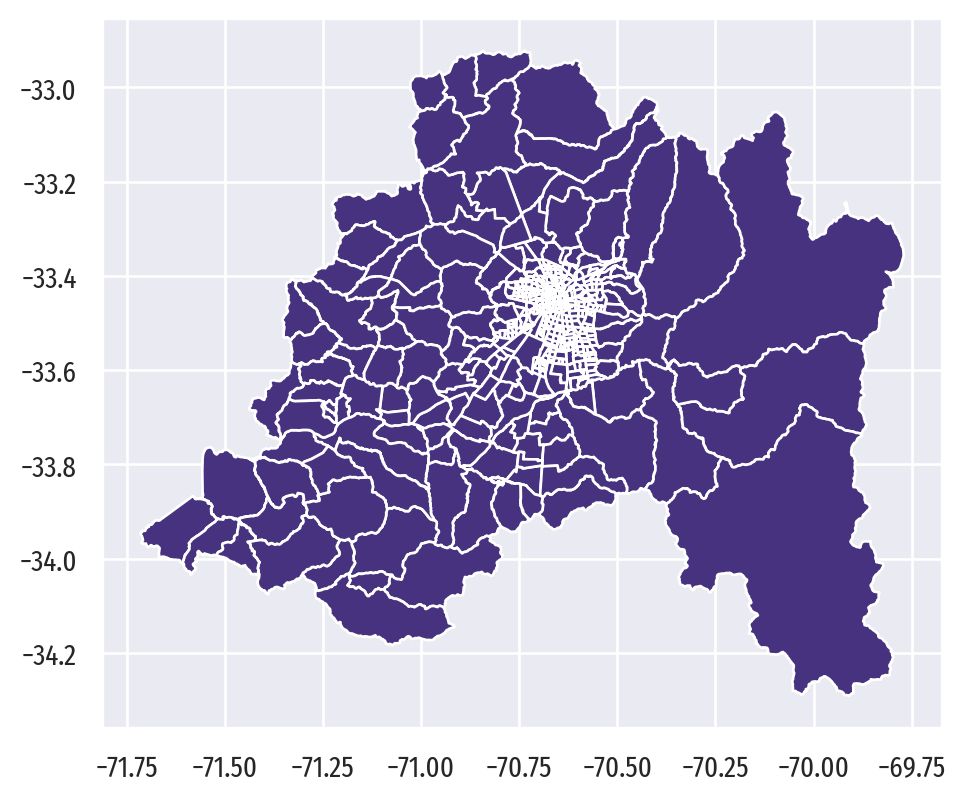

In [16]:
orig.plot()

Como está toda la región, necesitamos quedarnos con los distritos que se intersectan con el área urbana. Lo hacemos así:

In [17]:
urban_stgo

NOMBRE TIPO_AREA     SHAPE_Leng    SHAPE_Area  \
385  Santiago    Ciudad  427491.444262  5.821041e+08   

                                              geometry  
385  MULTIPOLYGON (((-70.73663 -33.37176, -70.73834...

In [18]:
# Definir una función para realizar la intersección de geometrías
def intersect_geometry(geom):
    return urban_stgo.loc[385].geometry.intersection(geom)

# Aplicar la intersección en la columna de geometría de 'orig'
orig['geometry'] = orig['geometry'].apply(intersect_geometry)

# Filtrar para mantener solo los distritos con área mayor a cero
urban_districts = orig[orig.geometry.area > 0].copy()

# Calcular la longitud de 'urban_districts'
len_urban_districts = len(urban_districts)
print(len_urban_districts)

342


<ipython-input-18-f5b2f636ba0f>:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  urban_districts = orig[orig.geometry.area > 0].copy()


<Axes: >

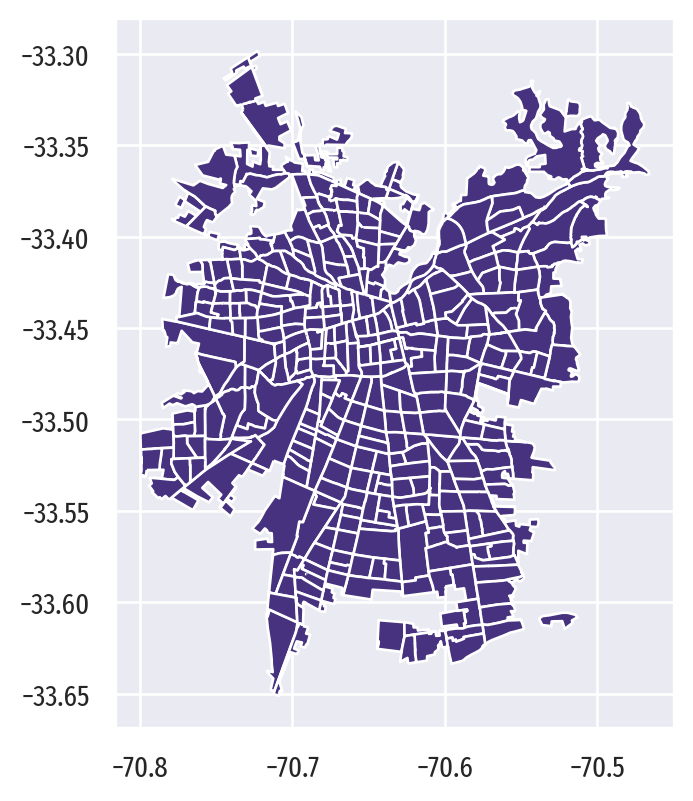

In [19]:
urban_districts.plot(edgecolor='white')

In [20]:
urban_districts.head()

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0      13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1      13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2      13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3      13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4      13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   

  DESC_PROVI  DESC_COMUN               DESC_DISTR  \
0   SANTIAGO  LAS CONDES               LAS CONDES   
1   SANTIAGO  LAS CONDES  SAN CARLOS DE APOQUINDO   
2   SANTIAGO  LAS CONDES              CERRO CALÁN   
3   SANTIAGO  LAS CONDES        ESTADIO PALESTINO   
4   SANTIAGO  LAS CONDES            HOSPITAL FACH   

                                            geometry  
0  POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...  
1  POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...  
2  POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...  
3  POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...  
4  POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...

Podemos guardar este mapa para utilizarlo más adelante.

In [21]:
!mkdir -p output

In [22]:
# Utilizamos el método 'to_file' del GeoDataFrame 'urban_districts' para guardar los datos geográficos.
# Este método permite exportar el GeoDataFrame a un archivo en un formato específico, en este caso, un shapefile.
urban_districts.to_file('output/stgo_urban_districts.shp', driver='ESRI Shapefile')

# El primer argumento 'output/stgo_urban_districts.shp' indica la ruta de archivo y el nombre bajo el cual se guardará el archivo.


Ahora mezclémoslos con los datos.

In [23]:
urban_data = urban_districts.merge(dc_values, how='inner')

In [24]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
337      13        134   13401           7  REGIÓN METROPOLITANA DE SANTIAGO   
338      13        134   13401          14  REGIÓN METROPOLITANA DE SANTIAGO   
339      13        133   13301           3  REGIÓN METROPOLITANA DE SANTIAGO   
340      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
341      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI    DESC_COMUN                      DESC_DISTR  \
0     SANTIAGO    LAS CONDES                      LAS CONDES   
1     SANTIAGO    LAS CONDES         SAN CARLOS DE APOQUINDO   
2     SANTIAGO    LAS CONDES                     CERRO CALÁN   
3     SANTIAGO    LAS CONDES               ESTADIO PALESTINO   
4     SANTIAGO    LAS CONDES                   HOSPITAL FACH   
..         ...           ...                             ...   
337      MAIPO  SAN BERNARDO                      MAESTRANZA   
338      MAIPO  SAN BERNARDO                      LOS MORROS   
339  CHACABUCO        COLINA                      ALGARROBAL   
340  CHACABUCO         LAMPA                       LA VILANA   
341   SANTIAGO         MACUL  VILLA SANTA CAROLINA VILLA SAN   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...     7140     8978   
1    POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
337  MULTIPOLYGON (((-70.69203 -33.60014, -70.69268...     5663     6018   
338  POLYGON ((-70.69306 -33.61304, -70.68962 -33.6...    14587    15143   
339  POLYGON ((-70.72257 -33.29815, -70.72153 -33.3...     6735     6618   
340  POLYGON ((-70.73333 -33.32757, -70.73456 -33.3...    32895    32577   
341  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  
0        1021       1562       10831         2466         1487  
1         936       2489       12392          884         1632  
2         616       1412        9940         2337         1180  
3         949        999        9862         2195         1632  
4        1033       1236       13872         2966         2716  
..        ...        ...         ...          ...          ...  
337      1091       1682        8210          468          165  
338      2906       4436       19995         1702          501  
339      1305       2070        8871          696         1137  
340      7632       8898       44553         1758         2757  
341       735        897        7854         1716          613  

[342 rows x 16 columns]

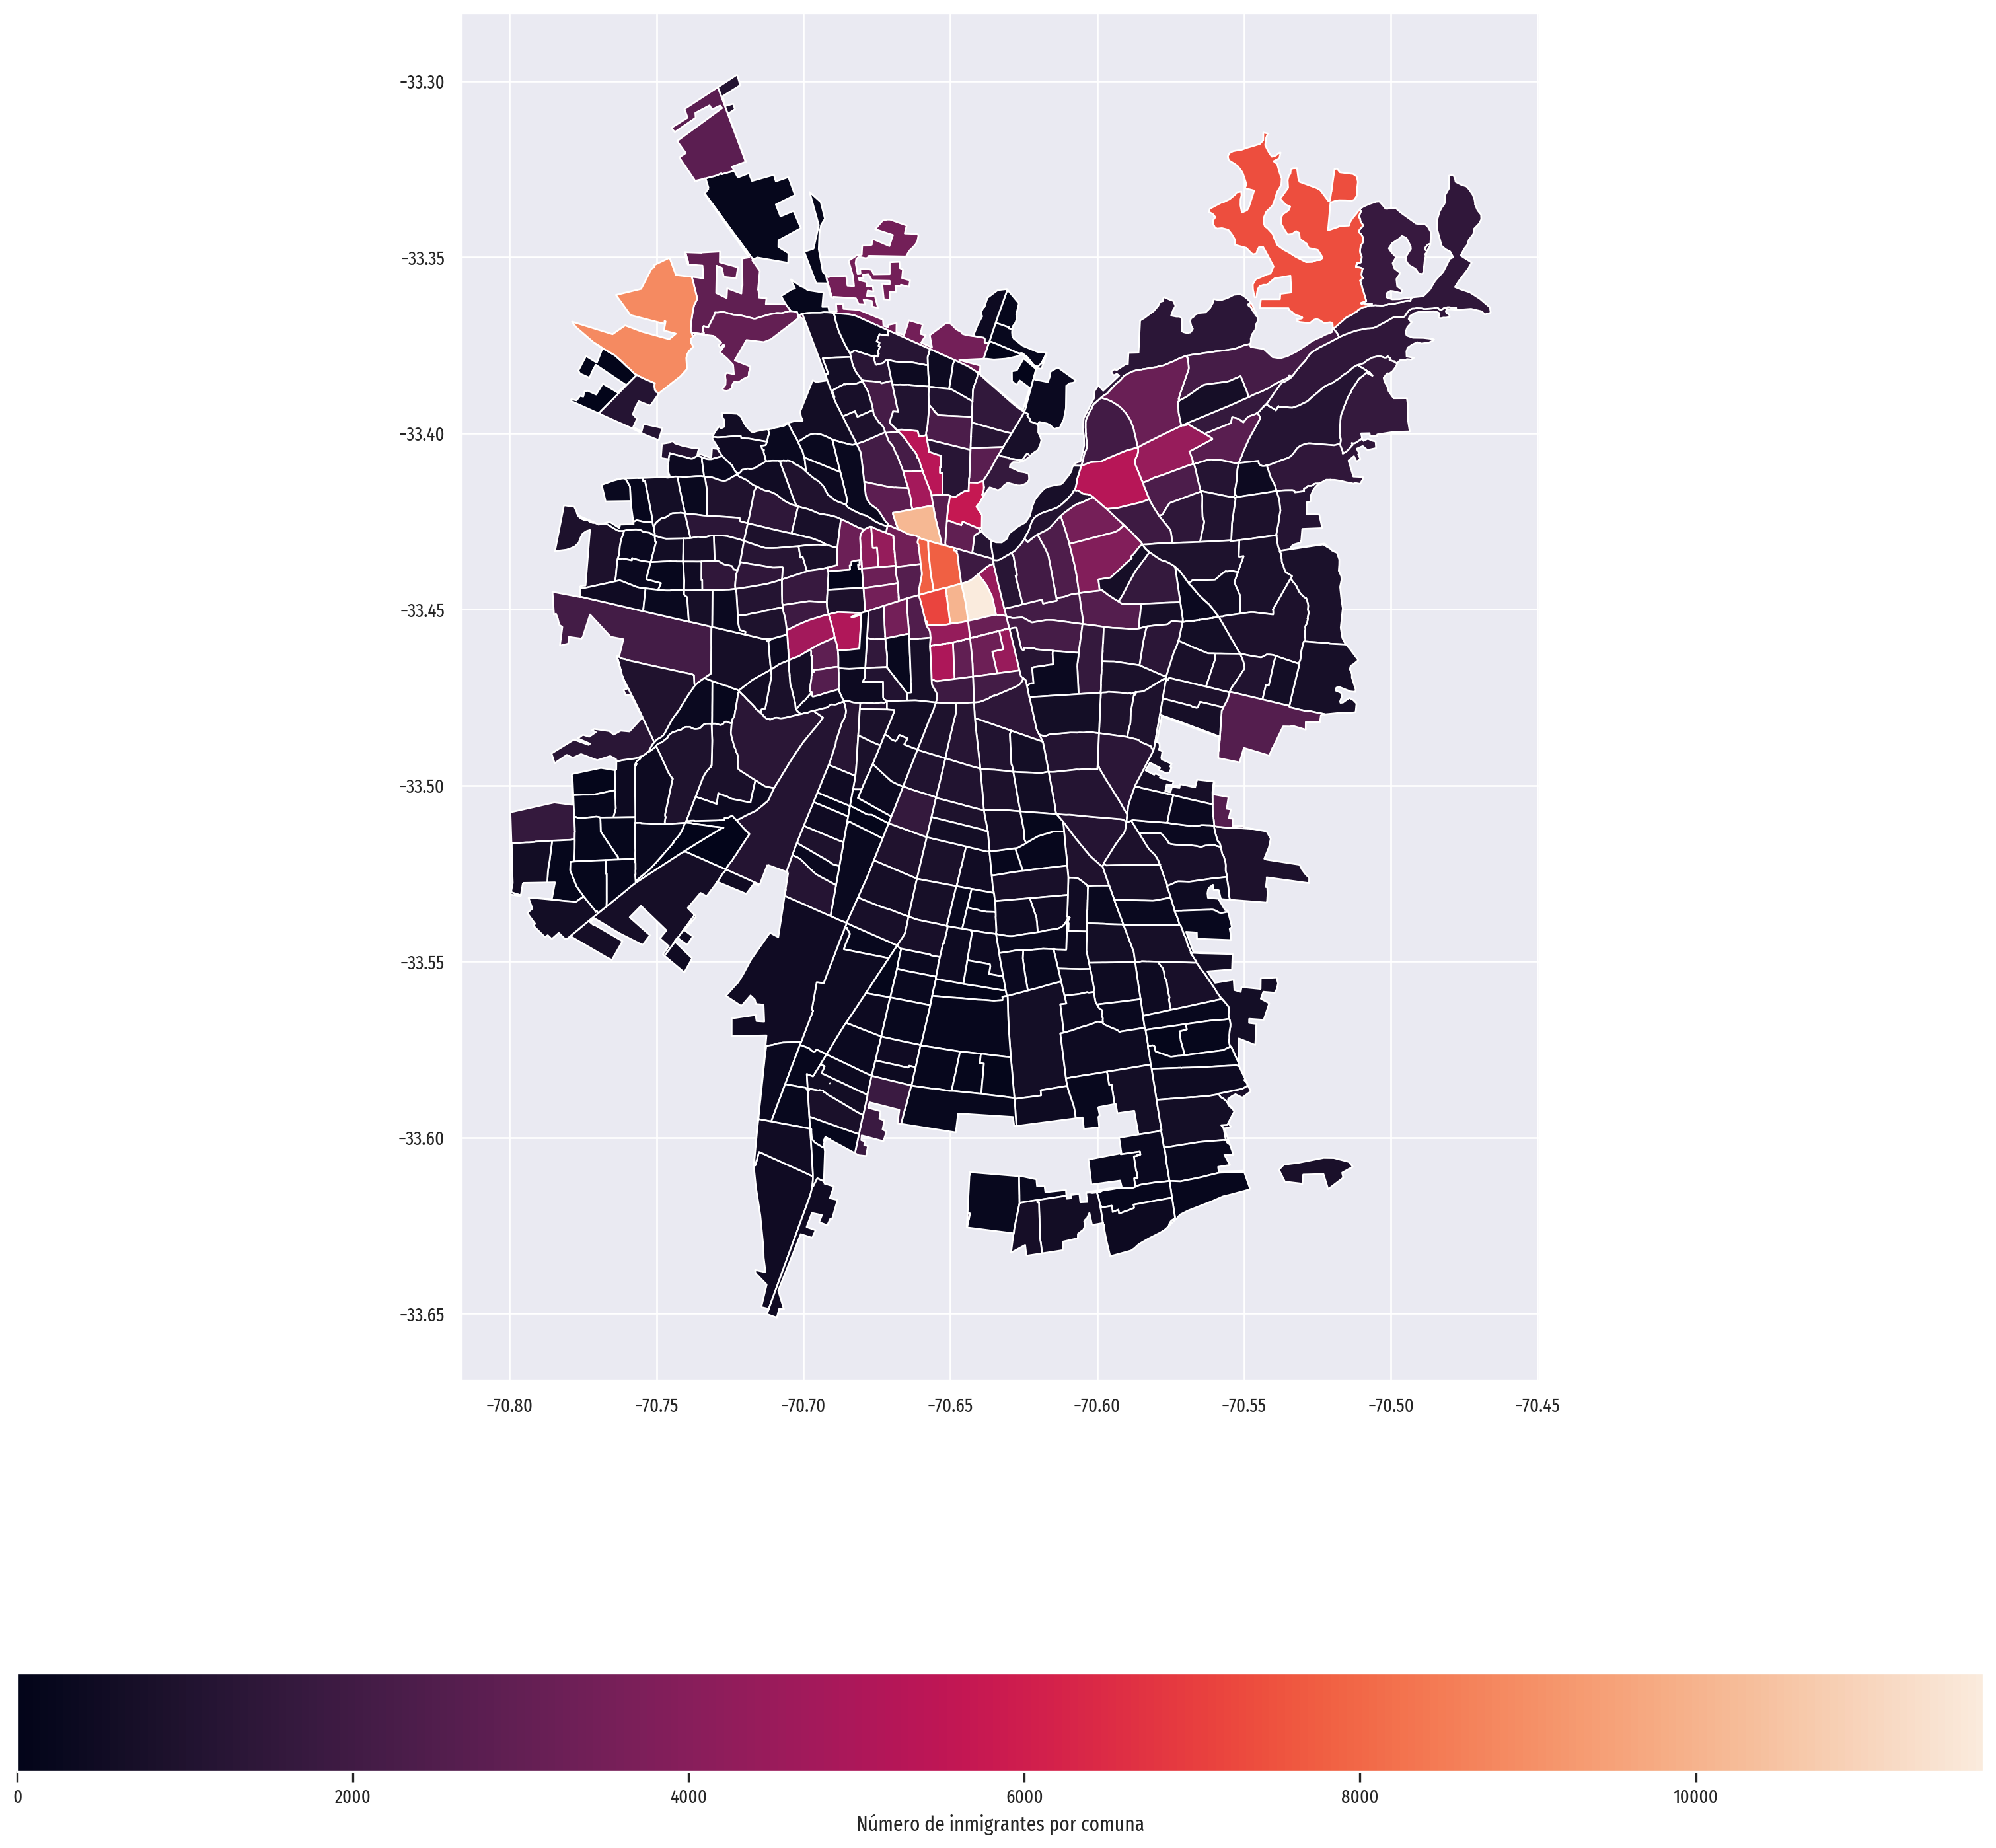

In [25]:
# Un gráfico de coropletas es útil para mostrar la variación de una variable medida en regiones geográficas.

# Se configura una figura y un eje con Matplotlib, especificando el tamaño de la figura.
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Se utiliza el método 'plot' del GeoDataFrame 'urban_data' para crear el mapa de cloropletas.
# 'column='INMIGRANTES'' indica que los valores de la columna 'INMIGRANTES' determinarán el color de cada área en el mapa.
urban_data.plot(column='INMIGRANTES', ax=ax, legend=True,
         legend_kwds={'label': "Número de inmigrantes por comuna",  # Configura la etiqueta de la leyenda
                      'orientation': "horizontal"})  # Establece la orientación de la leyenda como horizontal

# Muestra el gráfico.
plt.show()

Calculemos las variables que necesitamos para responder nuestras preguntas iniciales.

In [26]:
urban_data['POPULATION'] = urban_data['HOMBRES'] + urban_data['MUJERES']
urban_data.POPULATION.describe()

count      342.000000
mean     17858.394737
std      12753.122789
min        440.000000
25%      11400.750000
50%      14643.500000
75%      20322.500000
max      98090.000000
Name: POPULATION, dtype: float64

In [27]:
# Calcular el ratio de diferencia porcentual entre mujeres y hombres respecto a la población total.
urban_data['RATIO'] = ((urban_data['MUJERES'] - urban_data['HOMBRES']) / urban_data['POPULATION'] * 100)

# Obtener estadísticas descriptivas de la columna 'RATIO' para entender su distribución, centralidad y dispersión.
urban_data.RATIO.describe()


count    342.000000
mean       2.742708
std        5.605334
min      -83.073011
25%        1.301957
50%        2.728653
75%        4.469270
max       11.570881
Name: RATIO, dtype: float64

**Interpretación de la variable RATIO:**

- Un RATIO positivo indica un mayor porcentaje de mujeres en comparación con hombres en la población.
- Un RATIO negativo sugiere un mayor porcentaje de hombres en comparación con mujeres.
- Un RATIO cercano a cero implica una distribución casi equitativa entre mujeres y hombres en esa área.

In [28]:
urban_data['INMIGRANT_%'] = urban_data['INMIGRANTES'] / urban_data['POPULATION'] * 100
urban_data['INMIGRANT_%'].describe()

count    342.000000
mean       8.224377
std        9.434377
min        0.000000
25%        2.399305
50%        4.916366
75%        8.813560
max       53.320236
Name: INMIGRANT_%, dtype: float64

In [29]:
urban_data['RETIRED_%'] = urban_data['EDAD_65YMAS'] / urban_data['POPULATION'] * 100
urban_data['RETIRED_%'].describe()

count    342.000000
mean      11.914783
std        4.043622
min        0.000000
25%        8.924081
50%       12.508958
75%       14.787759
max       20.260310
Name: RETIRED_%, dtype: float64

In [30]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
337      13        134   13401           7  REGIÓN METROPOLITANA DE SANTIAGO   
338      13        134   13401          14  REGIÓN METROPOLITANA DE SANTIAGO   
339      13        133   13301           3  REGIÓN METROPOLITANA DE SANTIAGO   
340      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
341      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI    DESC_COMUN                      DESC_DISTR  \
0     SANTIAGO    LAS CONDES                      LAS CONDES   
1     SANTIAGO    LAS CONDES         SAN CARLOS DE APOQUINDO   
2     SANTIAGO    LAS CONDES                     CERRO CALÁN   
3     SANTIAGO    LAS CONDES               ESTADIO PALESTINO   
4     SANTIAGO    LAS CONDES                   HOSPITAL FACH   
..         ...           ...                             ...   
337      MAIPO  SAN BERNARDO                      MAESTRANZA   
338      MAIPO  SAN BERNARDO                      LOS MORROS   
339  CHACABUCO        COLINA                      ALGARROBAL   
340  CHACABUCO         LAMPA                       LA VILANA   
341   SANTIAGO         MACUL  VILLA SANTA CAROLINA VILLA SAN   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...     7140     8978   
1    POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
337  MULTIPOLYGON (((-70.69203 -33.60014, -70.69268...     5663     6018   
338  POLYGON ((-70.69306 -33.61304, -70.68962 -33.6...    14587    15143   
339  POLYGON ((-70.72257 -33.29815, -70.72153 -33.3...     6735     6618   
340  POLYGON ((-70.73333 -33.32757, -70.73456 -33.3...    32895    32577   
341  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  POPULATION  \
0        1021       1562       10831         2466         1487       16118   
1         936       2489       12392          884         1632       17160   
2         616       1412        9940         2337         1180       14591   
3         949        999        9862         2195         1632       14323   
4        1033       1236       13872         2966         2716       19597   
..        ...        ...         ...          ...          ...         ...   
337      1091       1682        8210          468          165       11681   
338      2906       4436       19995         1702          501       29730   
339      1305       2070        8871          696         1137       13353   
340      7632       8898       44553         1758         2757       65472   
341       735        897        7854         1716          613       11562   

         RATIO  INMIGRANT_%  RETIRED_%  
0    11.403400     9.225710  15.299665  
1     5.361305     9.510490   5.151515  
2     8.094031     8.087177  16.016723  
3     8.175662    11.394261  15.325002  
4     7.373578    13.859264  15.134970  
..         ...          ...        ...  
337   3.039123     1.412550   4.006506  
338   1.870165     1.685166   5.724857  
339  -0.876208     8.514940   5.212312  
340  -0.485704 

## ¡Mapas!

Ahora que calculamos las variables necesarias, grafiquemos los mapas :D

In [31]:
# Calcular los límites de los intervalos para 5 bins
bins = np.linspace(urban_data['INMIGRANTES'].min(), urban_data['INMIGRANT_%'].max(), 6)  # 5 bins, 6 límites

# Inicializar una lista vacía para almacenar las etiquetas
labels = []

# Usar un bucle for para crear etiquetas para cada bin
for i in range(len(bins) - 1):
    start = int(bins[i])  # Inicio del intervalo
    end = int(bins[i+1])  # Fin del intervalo
    label = f"{start}-{end}"  # Crear la etiqueta como un rango
    labels.append(label)  # Añadir la etiqueta a la lista

# Discretizar la columna 'INMIGRANTES' usando los bins y las etiquetas
urban_data['INMIGRANTES_CAT'] = pd.cut(urban_data['INMIGRANT_%'], bins=bins, labels=labels, include_lowest=True)

In [32]:
bins

array([ 0.        , 10.66404715, 21.3280943 , 31.99214145, 42.65618861,
       53.32023576])

In [33]:
labels

['0-10', '10-21', '21-31', '31-42', '42-53']

**include_lowest=True** asegura que el límite más bajo se incluya en el primer bin, lo que es importante para incluir el valor mínimo de la columna en la categorización.

In [34]:
urban_data

REGION  PROVINCIA  COMUNA  COD_DISTRI                        DESC_REGIO  \
0        13        131   13114           4  REGIÓN METROPOLITANA DE SANTIAGO   
1        13        131   13114          15  REGIÓN METROPOLITANA DE SANTIAGO   
2        13        131   13114          16  REGIÓN METROPOLITANA DE SANTIAGO   
3        13        131   13114           2  REGIÓN METROPOLITANA DE SANTIAGO   
4        13        131   13114           3  REGIÓN METROPOLITANA DE SANTIAGO   
..      ...        ...     ...         ...                               ...   
337      13        134   13401           7  REGIÓN METROPOLITANA DE SANTIAGO   
338      13        134   13401          14  REGIÓN METROPOLITANA DE SANTIAGO   
339      13        133   13301           3  REGIÓN METROPOLITANA DE SANTIAGO   
340      13        133   13302           4  REGIÓN METROPOLITANA DE SANTIAGO   
341      13        131   13118           5  REGIÓN METROPOLITANA DE SANTIAGO   

    DESC_PROVI    DESC_COMUN                      DESC_DISTR  \
0     SANTIAGO    LAS CONDES                      LAS CONDES   
1     SANTIAGO    LAS CONDES         SAN CARLOS DE APOQUINDO   
2     SANTIAGO    LAS CONDES                     CERRO CALÁN   
3     SANTIAGO    LAS CONDES               ESTADIO PALESTINO   
4     SANTIAGO    LAS CONDES                   HOSPITAL FACH   
..         ...           ...                             ...   
337      MAIPO  SAN BERNARDO                      MAESTRANZA   
338      MAIPO  SAN BERNARDO                      LOS MORROS   
339  CHACABUCO        COLINA                      ALGARROBAL   
340  CHACABUCO         LAMPA                       LA VILANA   
341   SANTIAGO         MACUL  VILLA SANTA CAROLINA VILLA SAN   

                                              geometry  HOMBRES  MUJERES  \
0    POLYGON ((-70.48101 -33.36476, -70.48127 -33.3...     7140     8978   
1    POLYGON ((-70.49823 -33.38107, -70.49937 -33.3...     8120     9040   
2    POLYGON ((-70.50774 -33.38250, -70.50764 -33.3...     6705     7886   
3    POLYGON ((-70.53652 -33.38549, -70.53657 -33.3...     6576     7747   
4    POLYGON ((-70.54575 -33.39769, -70.54613 -33.3...     9076    10521   
..                                                 ...      ...      ...   
337  MULTIPOLYGON (((-70.69203 -33.60014, -70.69268...     5663     6018   
338  POLYGON ((-70.69306 -33.61304, -70.68962 -33.6...    14587    15143   
339  POLYGON ((-70.72257 -33.29815, -70.72153 -33.3...     6735     6618   
340  POLYGON ((-70.73333 -33.32757, -70.73456 -33.3...    32895    32577   
341  POLYGON ((-70.59881 -33.47482, -70.59882 -33.4...     5415     6147   

     EDAD_0A5  EDAD_6A14  EDAD_15A64  EDAD_65YMAS  INMIGRANTES  POPULATION  \
0        1021       1562       10831         2466         1487       16118   
1         936       2489       12392          884         1632       17160   
2         616       1412        9940         2337         1180       14591   
3         949        999        9862         2195         1632       14323   
4        1033       1236       13872         2966         2716       19597   
..        ...        ...         ...          ...          ...         ...   
337      1091       1682        8210          468          165       11681   
338      2906       4436       19995         1702          501       29730   
339      1305       2070        8871          696         1137       13353   
340      7632       8898       44553         1758         2757       65472   
341       735        897        7854         1716          613       11562   

         RATIO  INMIGRANT_%  RETIRED_% INMIGRANTES_CAT  
0    11.403400     9.225710  15.299665            0-10  
1     5.361305     9.510490   5.151515            0-10  
2     8.094031     8.087177  16.016723            0-10  
3     8.175662    11.394261  15.325002           10-21  
4     7.373578    13.859264  15.134970           10-21  
..         ...          ...        ...             ...  
337   3.039123     1.41255

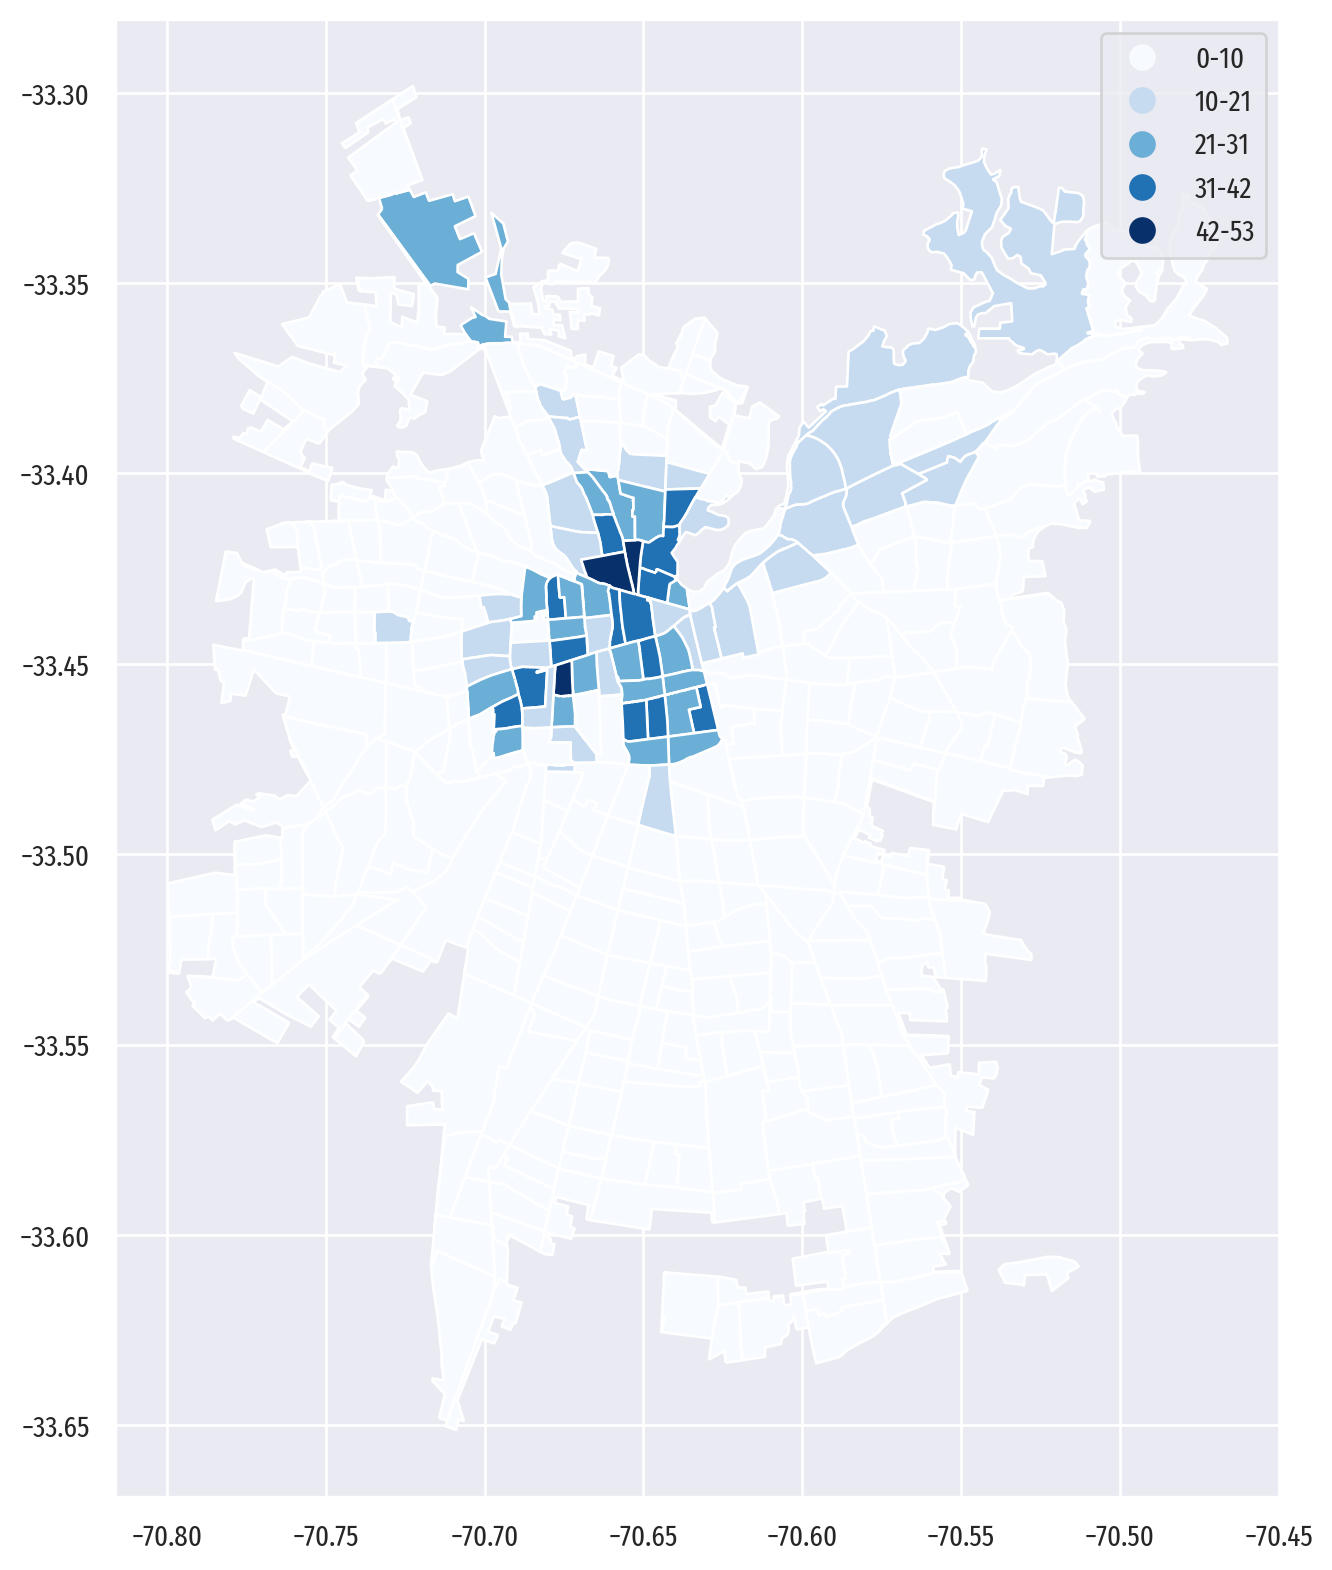

In [35]:
# Crear una paleta de colores con 32 colores
cmap = plt.get_cmap('Blues', 5)  # 'viridis' es un ejemplo de mapa de colores

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
divider = urban_data.plot(column='INMIGRANTES_CAT', ax=ax, legend=True, cmap=cmap)

plt.show()

Ahora vamos a dibujar los bordes del mapa

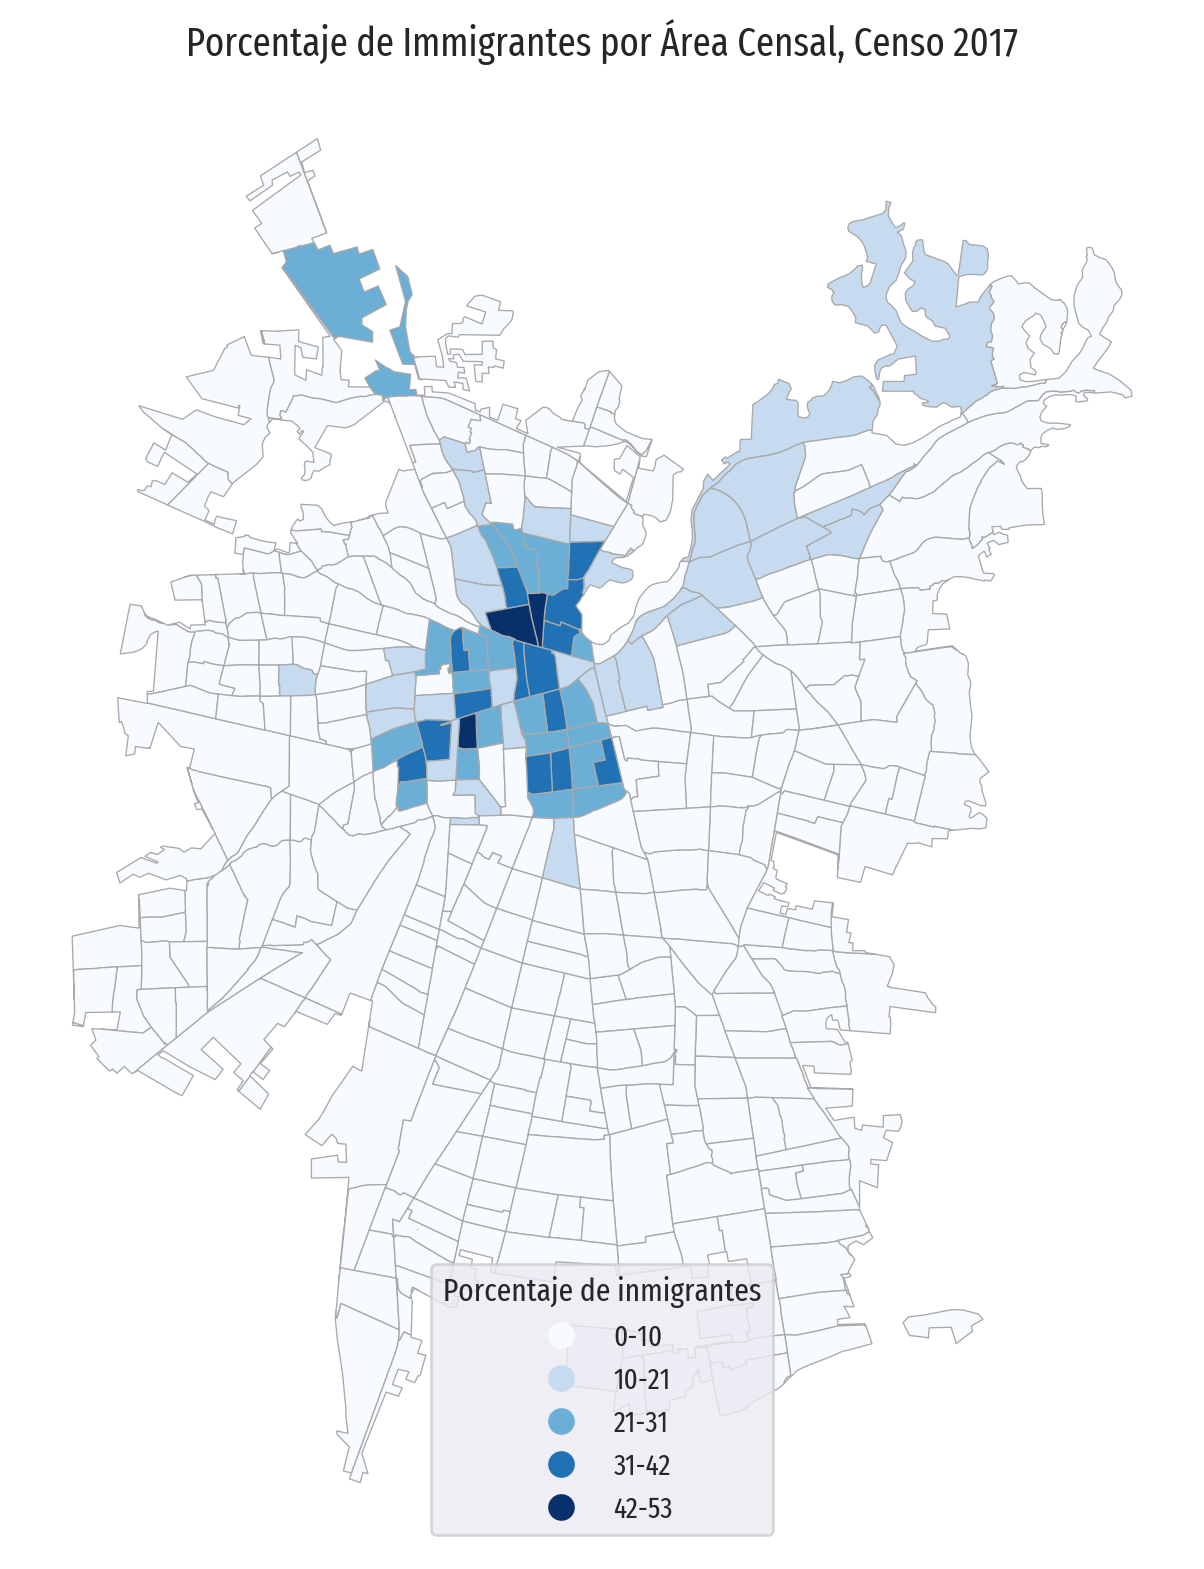

In [36]:
# Crear una paleta de colores con 5 tonos de azul
cmap = plt.get_cmap('Blues', 5)  # 'Blues' para usar tonos de azul

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data.plot(column='INMIGRANTES_CAT', ax=ax, legend=True, cmap=cmap, edgecolor='darkgrey', linewidth=0.5,# Añade bordes grises oscuros
                legend_kwds={'title': "Porcentaje de inmigrantes", 'loc': 'lower center'})
# Agregar título y ajustes adicionales
ax.set_title("Porcentaje de Immigrantes por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()


La leyenda nos molesta así que vamos a ponerla en una posicion tal que no choque con el mapa

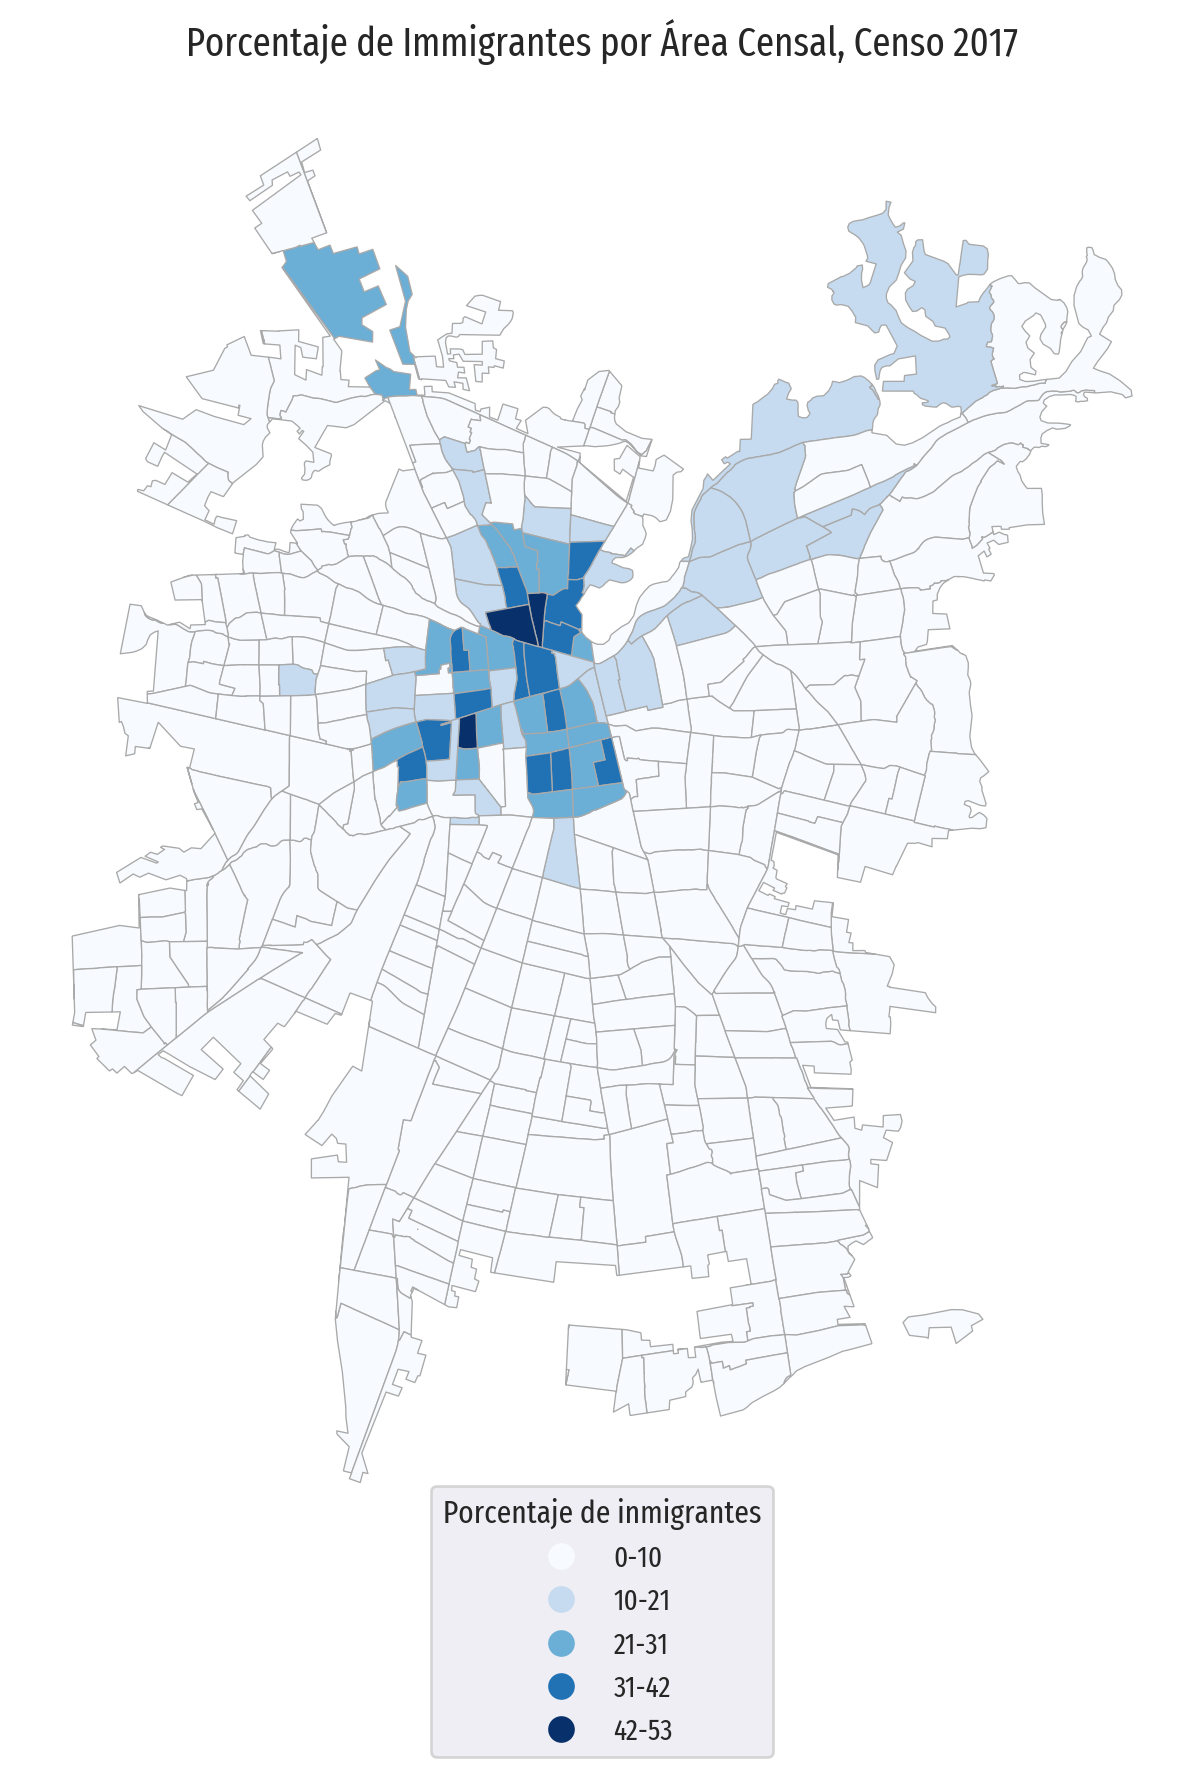

In [37]:
# Crear una paleta de colores con 5 tonos de azul
cmap = plt.get_cmap('Blues', 5)  # 'Blues' para usar tonos de azul

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data.plot(column='INMIGRANTES_CAT', ax=ax, legend=True,
                cmap=cmap, edgecolor='darkgrey', linewidth=0.5,
                legend_kwds={'title': "Porcentaje de inmigrantes", 'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.15)})

# Agregar título y ajustes adicionales
ax.set_title("Porcentaje de Immigrantes por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()


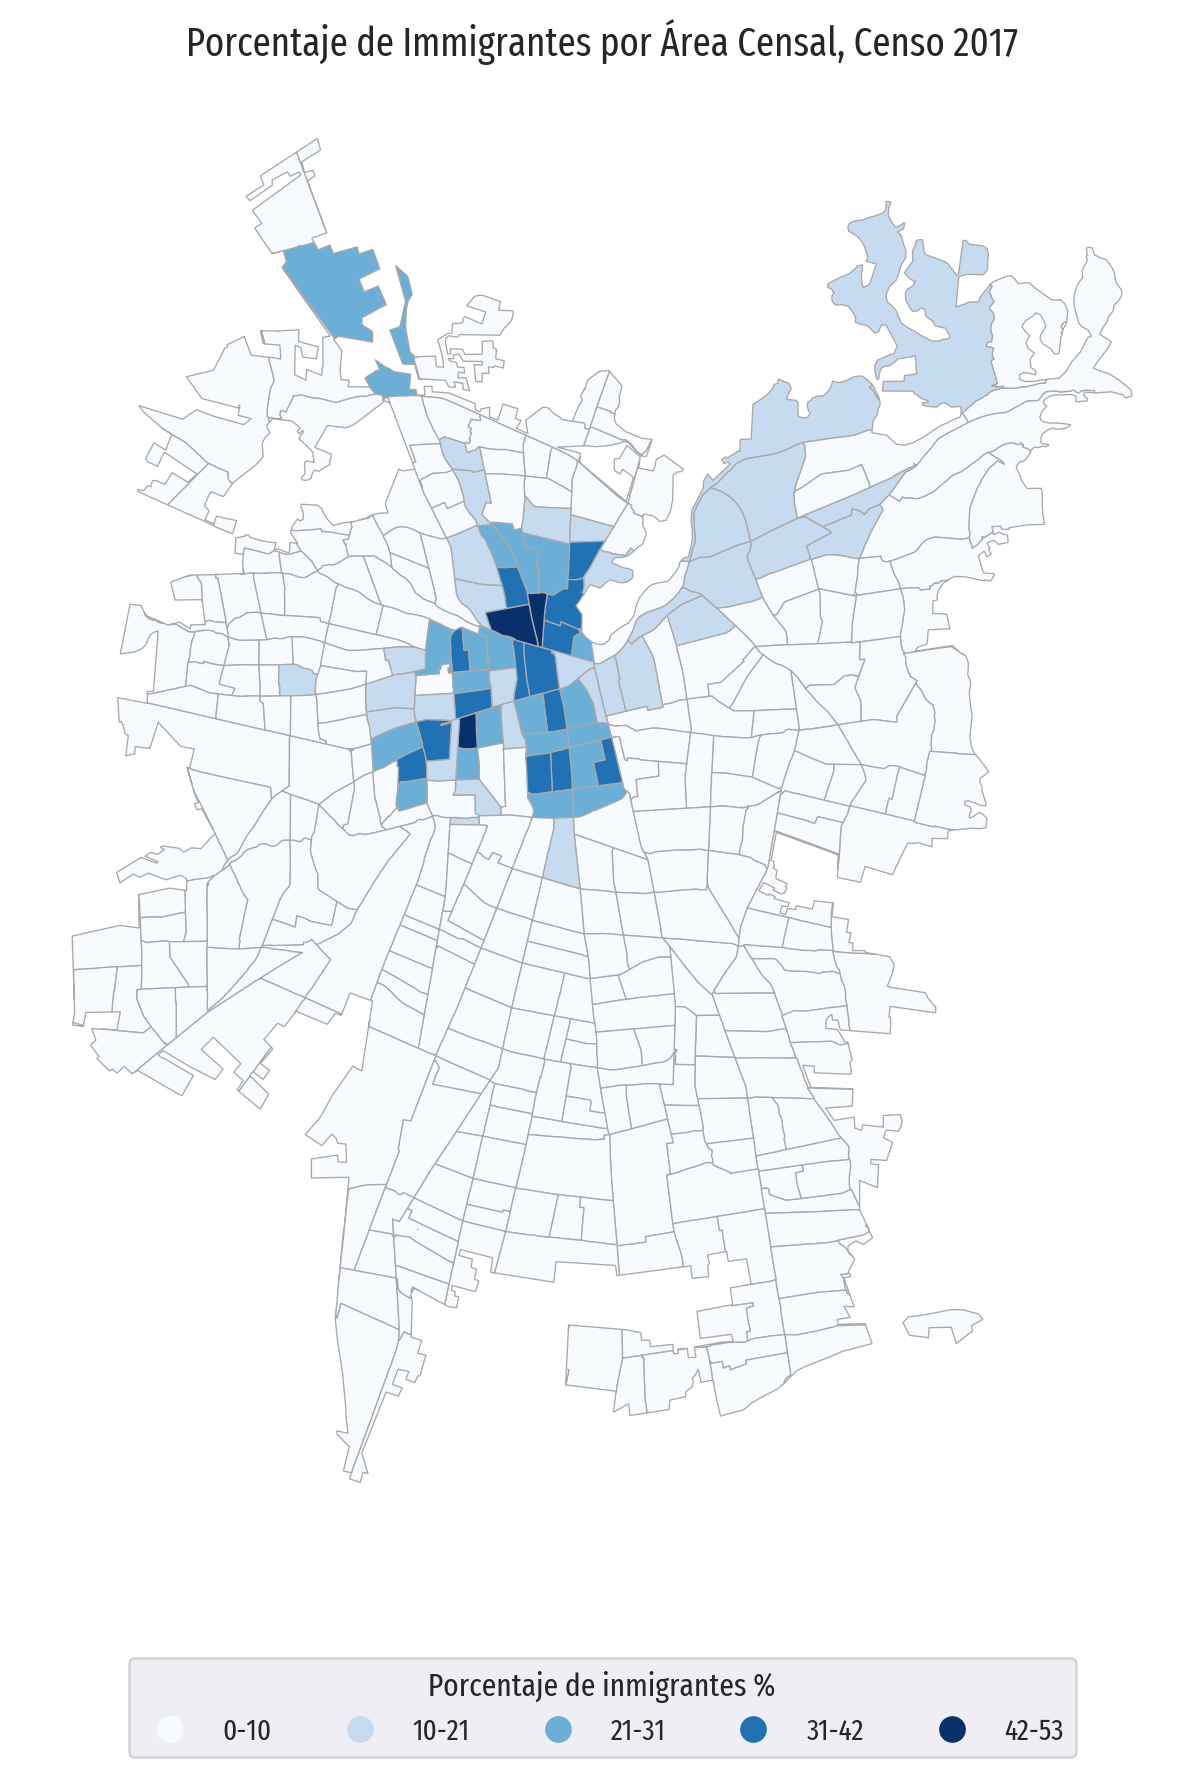

In [38]:
# Crear una paleta de colores con 5 tonos de azul
cmap = plt.get_cmap('Blues', 5)  # 'Blues' para usar tonos de azul

# Dibujar el gráfico de cloropletas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
urban_data.plot(column='INMIGRANTES_CAT', ax=ax, legend=True,
                cmap=cmap, edgecolor='darkgrey', linewidth=0.5,
                legend_kwds={'title': "Porcentaje de inmigrantes %", 'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.15), 'ncol':5})

# Agregar título y ajustes adicionales
ax.set_title("Porcentaje de Immigrantes por Área Censal, Censo 2017", fontsize=15)
ax.set_axis_off()  # Opcional: elimina los ejes para una visualización más limpia

plt.show()


In [39]:
!mkdir -p censo2017_figuras

In [40]:
fig.savefig('censo2017_figuras/migrants.png', dpi=150, bbox_inches='tight')

# Actividad 1

Cree un mapa coroplético de la columna **'Retirados'**, asegurándose de incluir una leyenda explicativa.Utilice una paleta distinta a 'Blues'. Analice y discuta las áreas con alta y baja concentración de personas retiradas, y presente sus hallazgos en forma de una breve.

Puntaje: 0.5 pts base de nota en el próximo control

# Actividad 2

Cree una visualización de coropletas en donde visualice la columna RATIO (la relacion entre el numero de mujeres y hombres) y que muestre en donde el porcentaje de mujeres es mayor o menor que los hombres. Us
e una paleta divergente. Ponga atención a la creación de los bins.

Puntaje: 0.5 pts base de nota en el próximo control

## Fin

Con eso terminamos este ejercicio. Hay hartos caminos por seguir:

  * ¿Cómo interpretarías estos datos?¿Qué hipótesis tienes respecto a los resultados?
  * ¿Con cuáles datasets los cruzarías?
  * ¿Qué otras ciudades te gustaría ver? En teoría solamente debemos cambiar el área urbana que estudiamos, el código debiese ser el mismo (excepto para el mapa de mujeres/hombres, en el que hay que ajustar las _bins_ de la escala de colores).
  